In [1]:
import pandas as pd
import numpy as np
import json

from imblearn.over_sampling import SMOTE
from scipy.stats import skew, kurtosis
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_recall_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
df_labels= 'data/data.info.txt'
df_labels = pd.read_csv(df_labels, delimiter=',')

df_raw = 'data/dataset0.json'

# Open the file and read line by line (each line = one read)
with open(df_raw, 'r') as file:
    data_list = []
    for line in file:
        try:
            data = json.loads(line)  # Parse each line as a separate JSON object
            data_list.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON on line: {line}")
            print(f"Error message: {e}")

In [3]:
start_idx = 0
end_idx = 5

# iterate through 5-mers for the 7-mer, 
# out of all the first 5-mers, what is the proportion of the 5-mer
def compute_sequence_proportions(data_list, start_idx, stop_idx):
    """ 
    New function that takes in the data list and produces proportions of the occurence of the sequence
        start_idx: 0-indexed (if referring to first index, use 0)
        stop_idx: if stopping at second index, use 2
    """
    sequence_counter = Counter()
    total_sequences = 0

    # First pass: Count the occurrences of each sequence
    for data in data_list:
        for transcript_id, positions in data.items():
            for position, sequence_data in positions.items():
                for sequence in sequence_data.keys():
                    sequence = sequence[start_idx:stop_idx]
                    sequence_counter[sequence] += 1
                    total_sequences += 1

    # Compute the proportion for each sequences
    sequence_proportions = {seq: count / total_sequences for seq, count in sequence_counter.items()}
    return sequence_proportions

sequence_proportions_1 = compute_sequence_proportions(data_list, start_idx, end_idx)
sequence_proportions_2 = compute_sequence_proportions(data_list, start_idx+1, end_idx+1)
sequence_proportions_3 = compute_sequence_proportions(data_list, start_idx+2, end_idx+2)

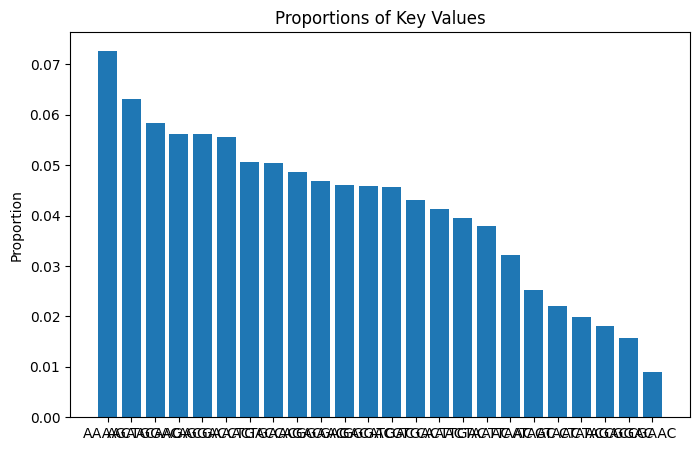

In [4]:
sorted_data = dict(sorted(sequence_proportions_1.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(8, 5))
plt.bar(sorted_data.keys(), sorted_data.values())
plt.ylabel('Proportion')
plt.title('Proportions of Key Values')
plt.show()

In [5]:
# test to understand 

start_idx = 0
end_idx = 5

transcript_id = "ENST00000000233"
position = "244"

# sequence data 
sequence = "AAGACCA"
measurements = [[0.00299,2.06,125.0,0.0177,10.4,122.0,0.0093,10.9,84.1],
[0.00631,2.53,125.0,0.00844,4.67,126.0,0.0103,6.3,80.9],[0.00465,3.92,109.0,0.0136,12.0,124.0,0.00498,2.13,79.6], [0.00398,2.06,125.0,0.0083,5.01,130.0,0.00498,3.78,80.4],[0.00664,2.92,120.0,0.00266,3.94,129.0,0.013,7.15,82.2], [0.0103,3.83,123.0,0.00598,6.45,126.0,0.0153,1.09,74.8],[0.00398,3.75,126.0,0.00332,4.3,129.0,0.00299,1.93,81.9], [0.00498,3.93,127.0,0.00398,2.51,131.0,0.0111,3.47,79.4]]

scores_array = np.array(measurements)

# perform aggregate functions along columns 
# essentially getting mean, var, max etc. for dwell, sd and mean at -1, 0, 1
mean_scores = np.mean(scores_array, axis=0)
var_scores = np.var(scores_array, axis=0)
max_scores = np.max(scores_array, axis=0)
min_scores = np.min(scores_array, axis=0)
skew_scores = skew(scores_array, axis=0) # mean, median, mode not the same
kurtosis_scores = kurtosis(scores_array, axis=0) # how data disperse between distribution center and tails, 
# larger values -> heavy tails that are thickly concentrated with observations or that are long with extreme observation

# get 5-mers from the 7-mer, e.g. AAGACCA -> AAGAC, AGACC, GACCA
sequence_1 = sequence[start_idx:end_idx]
sequence_2 = sequence[start_idx+1:end_idx+1]
sequence_3 = sequence[start_idx+2:end_idx+2]

# mean of the diffs between the dwell time at positions -1 and 0 
measurement_diff_mean_dwell_one = np.mean(scores_array[:, 3] - scores_array[:, 0])
# mean of the diffs between the sd at positions -1 and 0 
measurement_diff_mean_sd_one = np.mean(scores_array[:, 4] - scores_array[:, 1])
# mean of the diffs between the mean at positions -1 and 0 
measurement_diff_mean_mean_one = np.mean(scores_array[:, 5] - scores_array[:, 2])

# do the same for the measurements at positions 0 and 1 
measurement_diff_mean_dwell_two = np.mean(scores_array[:, 6] - scores_array[:, 3])
measurement_diff_mean_sd_two = np.mean(scores_array[:, 7] - scores_array[:, 4])
measurement_diff_mean_mean_two = np.mean(scores_array[:, 8] - scores_array[:, 5])

# for each transcript position, 13 features 
transcript_position = {
                        'transcript_id': transcript_id, # e.g. "ENST00000000233"
                        'transcript_position': position, # e.g. 244
                        'proportion_1': sequence_proportions_1[sequence_1], # proportion of first 5-mer e.g.AAGAC
                        'proportion_2': sequence_proportions_2[sequence_2], # proportion of second 5-mer
                        'proportion_3': sequence_proportions_3[sequence_3], # proportion of third 5-mer
                        'pos': int(position), # 244
                        'diff_1_1': measurement_diff_mean_dwell_one, # mean of the diffs between the dwell time at positions -1 and 0 
                        'diff_1_2': measurement_diff_mean_sd_one, # mean of the diffs between the sd at positions -1 and 0 
                        'diff_1_3': measurement_diff_mean_mean_one , # mean of the diffs between the mean at positions -1 and 0 
                        'diff_2_1': measurement_diff_mean_dwell_two , # mean of the diffs between the dwell time at positions 0 and 1
                        'diff_2_2': measurement_diff_mean_sd_two, # mean of the diffs between the sd at positions 0 and 1
                        'diff_2_3': measurement_diff_mean_mean_two, # mean of the diffs between the mean at positions 0 and 1
                        'length': len(measurements) # number of measurements (reads) for the transcript_position
                    }

# for each measurement in one read, e.g. dwell, sd and mean at -1, 0, 1
for idx in range(scores_array.shape[1]): 
    # add the mean, var, max, min, skew and kurtosis 
    transcript_position.update({
        f'mean_{idx}': mean_scores[idx],
        f'var_{idx}': var_scores[idx],
        f'max_{idx}': max_scores[idx],
        f'min_{idx}': min_scores[idx],
        f'skewness_{idx}': skew_scores[idx],
        f'kurtosis_{idx}': kurtosis_scores[idx]
    })
# result should be 9 measurements x 6 aggregation functions -> 54 new features 

# for each measurement, dwell, sd and mean
# add all the aggregated scores for all three positions 
# e.g. mean_0c should be sum of means of dwell at position -1, 0 and 1
for i in range(3):
    transcript_position.update({
            f'mean_{i}c': mean_scores[i] + mean_scores[i+3] + mean_scores[i+6],
            f'var_{i}c': var_scores[i] + var_scores[i+3] + var_scores[i+6],
            f'max_{i}c': max_scores[i] + max_scores[i+3] + max_scores[i+6],
            f'min_{i}c': min_scores[i] + min_scores[i+3] + min_scores[i+6],
            f'skewness_{i}c': skew_scores[i] + skew_scores[i+3] + skew_scores[i+6],
            f'kurtosis_{i}c': kurtosis_scores[i] + kurtosis_scores[i+3] + skew_scores[i+6]
        })
# 3 measurements (dwell, sd and mean) x 6 aggregation functions -> 18

# total features = 13 + 54 + 18 = 85
    
transcript_position.keys()

dict_keys(['transcript_id', 'transcript_position', 'proportion_1', 'proportion_2', 'proportion_3', 'pos', 'diff_1_1', 'diff_1_2', 'diff_1_3', 'diff_2_1', 'diff_2_2', 'diff_2_3', 'length', 'mean_0', 'var_0', 'max_0', 'min_0', 'skewness_0', 'kurtosis_0', 'mean_1', 'var_1', 'max_1', 'min_1', 'skewness_1', 'kurtosis_1', 'mean_2', 'var_2', 'max_2', 'min_2', 'skewness_2', 'kurtosis_2', 'mean_3', 'var_3', 'max_3', 'min_3', 'skewness_3', 'kurtosis_3', 'mean_4', 'var_4', 'max_4', 'min_4', 'skewness_4', 'kurtosis_4', 'mean_5', 'var_5', 'max_5', 'min_5', 'skewness_5', 'kurtosis_5', 'mean_6', 'var_6', 'max_6', 'min_6', 'skewness_6', 'kurtosis_6', 'mean_7', 'var_7', 'max_7', 'min_7', 'skewness_7', 'kurtosis_7', 'mean_8', 'var_8', 'max_8', 'min_8', 'skewness_8', 'kurtosis_8', 'mean_0c', 'var_0c', 'max_0c', 'min_0c', 'skewness_0c', 'kurtosis_0c', 'mean_1c', 'var_1c', 'max_1c', 'min_1c', 'skewness_1c', 'kurtosis_1c', 'mean_2c', 'var_2c', 'max_2c', 'min_2c', 'skewness_2c', 'kurtosis_2c'])

In [4]:
# aggregating data_list
def create_aggregated_dataframe(data_list, sequence_proportions_1, sequence_proportions_2, sequence_proportions_3):
    rows = []
    for data in data_list:
        for transcript_id, positions in data.items():
            for position, sequence_data in positions.items():
                for sequence, measurements in sequence_data.items():
                    # Convert to numpy array for easier aggregation
                    scores_array = np.array(measurements)
                    
                    # Calculate the mean, variance, max, and min along the rows
                    mean_scores = np.mean(scores_array, axis=0)
                    var_scores = np.var(scores_array, axis=0)
                    max_scores = np.max(scores_array, axis=0)
                    min_scores = np.min(scores_array, axis=0)
                    skew_scores = skew(scores_array, axis=0)
                    kurtosis_scores = kurtosis(scores_array, axis=0)
                    sequence_1 = sequence[start_idx:end_idx]
                    sequence_2 = sequence[start_idx+1:end_idx+1]
                    sequence_3 = sequence[start_idx+2:end_idx+2]

                    measurement_diff_mean_dwell_one = np.mean(scores_array[:, 3] - scores_array[:, 0])
                    measurement_diff_mean_sd_one = np.mean(scores_array[:, 4] - scores_array[:, 1])
                    measurement_diff_mean_mean_one = np.mean(scores_array[:, 5] - scores_array[:, 2])

                    measurement_diff_mean_dwell_two = np.mean(scores_array[:, 6] - scores_array[:, 3])
                    measurement_diff_mean_sd_two = np.mean(scores_array[:, 7] - scores_array[:, 4])
                    measurement_diff_mean_mean_two = np.mean(scores_array[:, 8] - scores_array[:, 5])
                    transcript_position = {
                        'transcript_id': transcript_id,
                        'transcript_position': position,
                        'proportion_1': sequence_proportions_1[sequence_1],
                        'proportion_2': sequence_proportions_2[sequence_2],
                        'proportion_3': sequence_proportions_3[sequence_3],
                        'pos': int(position),
                        'diff_1_1': measurement_diff_mean_dwell_one,
                        'diff_1_2': measurement_diff_mean_sd_one,
                        'diff_1_3': measurement_diff_mean_mean_one ,
                        'diff_2_1': measurement_diff_mean_dwell_two ,
                        'diff_2_2': measurement_diff_mean_sd_two,
                        'diff_2_3': measurement_diff_mean_mean_two,
                        'length': len(measurements)
                    }
                    
                    for idx in range(scores_array.shape[1]): 
                        transcript_position.update({
                            f'mean_{idx}': mean_scores[idx],
                            f'var_{idx}': var_scores[idx],
                            f'max_{idx}': max_scores[idx],
                            f'min_{idx}': min_scores[idx],
                            f'skewness_{idx}': skew_scores[idx],
                            f'kurtosis_{idx}': kurtosis_scores[idx]
                        })
                    for i in range(3):
                        transcript_position.update({
                                f'mean_{i}c': mean_scores[i] + mean_scores[i+3] + mean_scores[i+6],
                                f'var_{i}c': var_scores[i] + var_scores[i+3] + var_scores[i+6],
                                f'max_{i}c': max_scores[i] + max_scores[i+3] + max_scores[i+6],
                                f'min_{i}c': min_scores[i] + min_scores[i+3] + min_scores[i+6],
                                f'skewness_{i}c': skew_scores[i] + skew_scores[i+3] + skew_scores[i+6],
                                f'kurtosis_{i}c': kurtosis_scores[i] + kurtosis_scores[i+3] + skew_scores[i+6]
                            })
                
                    rows.append(transcript_position)
        
    # Create DataFrame
    df = pd.DataFrame(rows)
    return df


# Create the DataFrame
aggregated_df = create_aggregated_dataframe(data_list, sequence_proportions_1, sequence_proportions_2, sequence_proportions_3)

In [5]:
aggregated_df.head()

,transcript_id,transcript_position,proportion_1,proportion_2,proportion_3,pos,diff_1_1,diff_1_2,diff_1_3,diff_2_1,...,max_1c,min_1c,skewness_1c,kurtosis_1c,mean_2c,var_2c,max_2c,min_2c,skewness_2c,kurtosis_2c
0,ENST00000000233,244,0.056173,0.055689,0.054655,244,0.001109,3.158378,2.210811,-0.002028,...,44.60,3.583,3.407331,4.500760,330.186486,38.454656,353.3,286.1,-3.600214,11.742933
1,ENST00000000233,261,0.041284,0.070807,0.053267,261,0.000204,0.010110,-1.791860,0.000897,...,42.60,2.423,10.001174,43.263423,311.861628,27.536551,334.0,283.0,-0.779251,2.807860
2,ENST00000000233,316,0.055508,0.083324,0.051150,316,-0.000154,0.702162,-6.528649,0.000140,...,24.68,2.930,4.082764,15.271188,293.787027,14.695492,313.2,274.1,-0.536376,2.783766
3,ENST00000000233,332,0.063051,0.065119,0.048015,332,-0.001988,-3.577150,-31.518500,-0.002531,...,37.59,3.504,8.399099,52.268315,316.345500,26.190777,337.7,284.9,-1.707681,11.218923
4,ENST00000000233,368,0.056099,0.063420,0.049935,368,0.000779,-0.544747,4.030303,-0.001460,...,61.31,4.870,9.803483,99.653998,325.057576,17.500533,346.5,299.6,-0.834535,2.593209


In [6]:
# set transcript_position to type int 
df_labels['transcript_position'] = df_labels['transcript_position'].astype(int)
aggregated_df['transcript_position'] = aggregated_df['transcript_position'].astype(int)

In [7]:
# perform left join with aggregated_df and labels_df to get gene_id and label 
df_full = pd.merge(aggregated_df, df_labels[['gene_id','transcript_id', 'transcript_position', 'label']],
                   on=['transcript_id', 'transcript_position'], how='left')
print(df_full.columns)
# drop transcript_id and position -> why? 
df = df_full.drop([
    'transcript_id',
    'transcript_position',
], axis = 1)

Index(['transcript_id', 'transcript_position', 'proportion_1', 'proportion_2',
       'proportion_3', 'pos', 'diff_1_1', 'diff_1_2', 'diff_1_3', 'diff_2_1',
       'diff_2_2', 'diff_2_3', 'length', 'mean_0', 'var_0', 'max_0', 'min_0',
       'skewness_0', 'kurtosis_0', 'mean_1', 'var_1', 'max_1', 'min_1',
       'skewness_1', 'kurtosis_1', 'mean_2', 'var_2', 'max_2', 'min_2',
       'skewness_2', 'kurtosis_2', 'mean_3', 'var_3', 'max_3', 'min_3',
       'skewness_3', 'kurtosis_3', 'mean_4', 'var_4', 'max_4', 'min_4',
       'skewness_4', 'kurtosis_4', 'mean_5', 'var_5', 'max_5', 'min_5',
       'skewness_5', 'kurtosis_5', 'mean_6', 'var_6', 'max_6', 'min_6',
       'skewness_6', 'kurtosis_6', 'mean_7', 'var_7', 'max_7', 'min_7',
       'skewness_7', 'kurtosis_7', 'mean_8', 'var_8', 'max_8', 'min_8',
       'skewness_8', 'kurtosis_8', 'mean_0c', 'var_0c', 'max_0c', 'min_0c',
       'skewness_0c', 'kurtosis_0c', 'mean_1c', 'var_1c', 'max_1c', 'min_1c',
       'skewness_1c', 'kurtosis_1c'

In [8]:
cluster_data = pd.read_pickle("clustered_dat_noscale.pkl")
pd.set_option('display.max_columns', None)
cluster_data['position'] = cluster_data['position'].astype(int)
merged_df = pd.merge(df_full, cluster_data, left_on=['transcript_id', 'transcript_position'], right_on=['transcript_id', 'position'], how='left')

cluster_data_2 = pd.read_pickle("clustered_data.pkl")
cluster_data_2['transcript_position'] = cluster_data_2['transcript_position'].astype(int)

cluster_data_3 = pd.read_pickle("clustered_data_3d.pkl")
cluster_data_3['transcript_position'] = cluster_data_3['transcript_position'].astype(int)
cluster_data_3 = cluster_data_3.rename(
    columns={col: f"{col}_3d" for col in cluster_data_3.columns if col not in ['transcript_id', 'transcript_position']}
)

# Merge the second dataset
merged_df = pd.merge(merged_df, cluster_data_2, left_on=['transcript_id', 'transcript_position'], right_on=['transcript_id', 'transcript_position'], how='left')
merged_df = pd.merge(merged_df, cluster_data_3, left_on=['transcript_id', 'transcript_position'], right_on=['transcript_id', 'transcript_position'], how='left')
df = merged_df
df_full = df.copy()
df = df.drop([
    'transcript_id',
    'transcript_position',
    'rna_sequence'
], axis = 1)

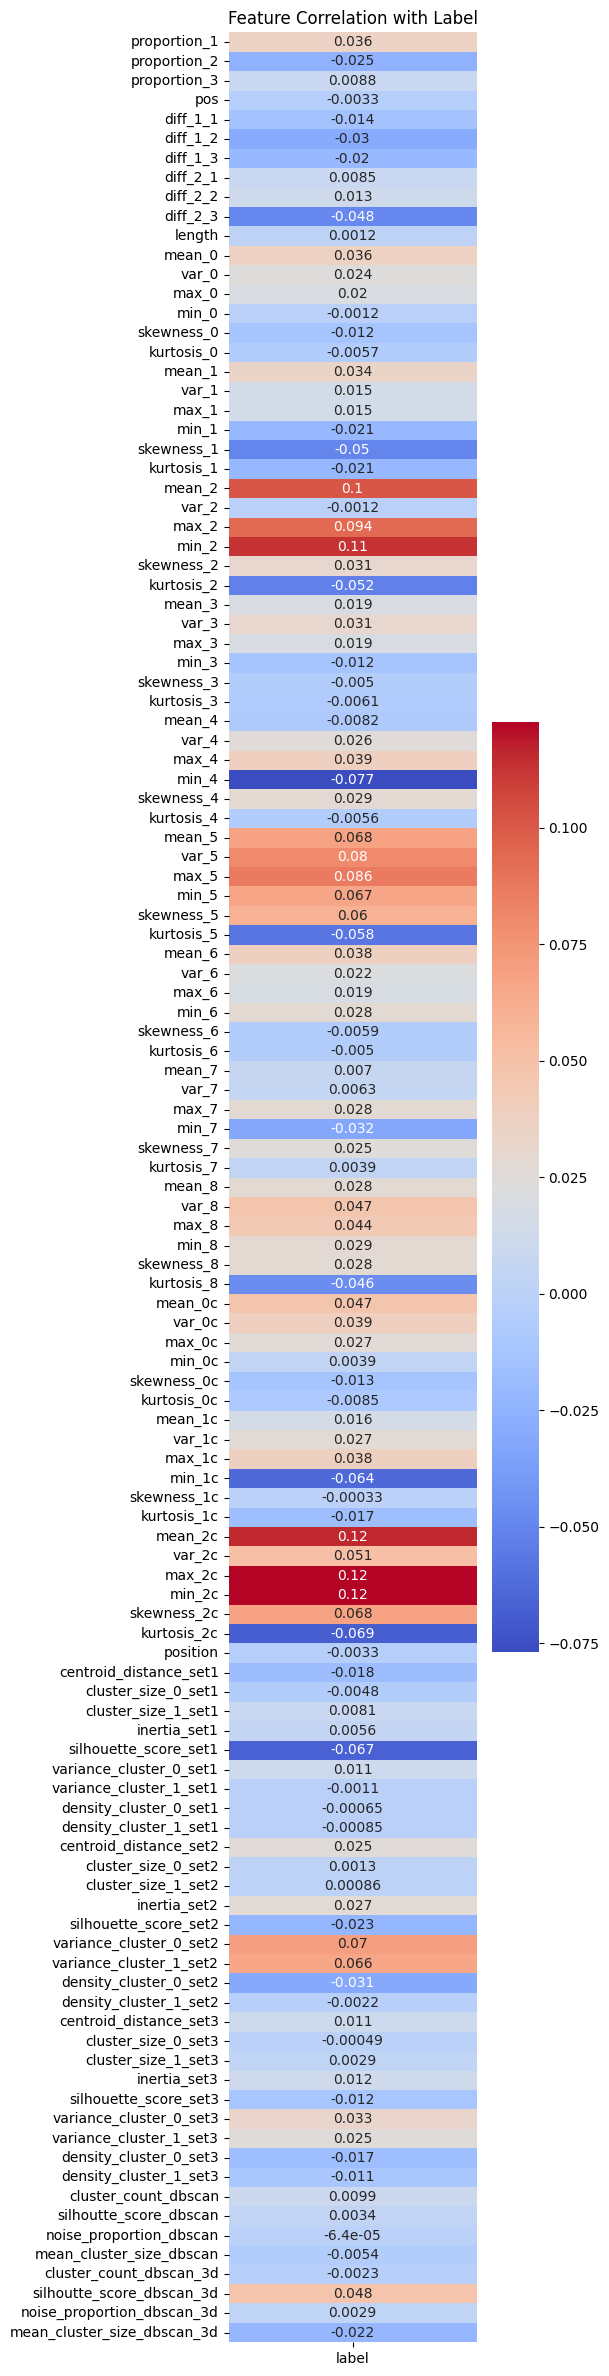

In [9]:
# Correlation heatmap
correlation_df = df.drop(['gene_id'], axis=1)
correlation_matrix = correlation_df.corr()
label_correlations = correlation_matrix['label'].drop('label')

plt.figure(figsize=(4, 30))
sns.heatmap(label_correlations.to_frame(), annot=True, cmap='coolwarm', cbar=True)
plt.title('Feature Correlation with Label')
plt.show()

In [10]:
df_final = df_full.copy()

y = df_final[['label', 'transcript_id', 'transcript_position', 'gene_id']]
x = df_final.drop(['label', 'rna_sequence'], axis=1)
print(x.columns)
# Extra features to drop if merged with clustering features
# x = df_final.drop(['label', 'position', 'rna_sequence'], axis=1)

print(df_final.shape[0])

Index(['transcript_id', 'transcript_position', 'proportion_1', 'proportion_2',
       'proportion_3', 'pos', 'diff_1_1', 'diff_1_2', 'diff_1_3', 'diff_2_1',
       ...
       'density_cluster_0_set3', 'density_cluster_1_set3',
       'cluster_count_dbscan', 'silhoutte_score_dbscan',
       'noise_proportion_dbscan', 'mean_cluster_size_dbscan',
       'cluster_count_dbscan_3d', 'silhoutte_score_dbscan_3d',
       'noise_proportion_dbscan_3d', 'mean_cluster_size_dbscan_3d'],
      dtype='object', length=122)
121838


In [11]:
# split data by gene_id

unique_gene_ids =  x['gene_id'].unique()

train_gene_ids, test_gene_ids = train_test_split(
    unique_gene_ids, test_size=0.1, random_state=42
)

# Create train and test sets by filtering based on gene_id
X_train = x[x['gene_id'].isin(train_gene_ids)]
X_test = x[x['gene_id'].isin(test_gene_ids)]

y_train = y[y['gene_id'].isin(train_gene_ids)]
y_test = y[y['gene_id'].isin(test_gene_ids)]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# check if ratio of 0 to 1 is somewhat similar 
print(y_train['label'].mean())
print(y_test['label'].mean())

X_train = X_train.drop(['transcript_id', 'transcript_position', 'gene_id'], axis = 1)
X_test = X_test.drop(['transcript_id', 'transcript_position', 'gene_id'], axis = 1)
y_train = y_train['label']
y_test = y_test['label']

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(109078, 122) (12760, 122) (109078, 4) (12760, 4)
0.04478446616182915
0.04623824451410658
(109078, 119) (12760, 119) (109078,) (12760,)


In [12]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

XGBoost

In [13]:
### XBOOST
print("XGBoost")
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss') #or logloss
model.fit(X_train_scaled, y_train)
x_test = X_test_scaled
y_check = y_test
y_pred = model.predict(x_test)

y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:, 1]

accuracy = accuracy_score(y_check, y_pred)
roc_auc = roc_auc_score(y_check, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_check, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_check, y_pred)

# Output the results
print("XGBoost - Base model")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

XGBoost


c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:23:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Base model
Accuracy: 0.9588557993730408
ROC AUC: 0.9035488767878779
PR AUC: 0.460575711087394
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     12170
           1       0.62      0.29      0.40       590

    accuracy                           0.96     12760
   macro avg       0.79      0.64      0.69     12760
weighted avg       0.95      0.96      0.95     12760



In [18]:
# Finding Best Params 

# Takes ~2 minutes to run

# Define the parameter grid
param_grid = {
    'n_estimators': [500, 800, 1000], # Default = 100
    'max_depth': [6, 10], # Default = 6
    'learning_rate': [0.01, 0.05], 
    'subsample': [0.6, 0.8,], # Default = 1
    'colsample_bytree': [0.6, 0.8, 1.0], # Default = 1
    'gamma': [0, 0.1, 0.05] # Default = 0
}

xgb_clf = XGBClassifier(random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best parameters found: ", random_search.best_params_)

Best parameters found:  {'subsample': 0.8, 'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}


In [14]:
# Set class weights
class_weights = {0: 1, 1: 10}

# Set "scale_pos_weights" based on class_balance
pos_weight = sum(class_weights.values()) / sum(class_weights.keys())

In [15]:
best_params = {'subsample': 0.8, 'n_estimators': 800, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}

print("XGBoost")
model = XGBClassifier(use_label_encoder=True, scale_pos_weight = pos_weight, class_weight = class_weights, eval_metric='logloss', **best_params)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test, y_pred)

# Output the results
print("Test Data Set - Param Searched Best XGB Model")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

model_xgb = model

XGBoost


c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:24:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Data Set - Param Searched Best XGB Model
Accuracy: 0.9594043887147335
ROC AUC: 0.9136009637480328
PR AUC: 0.5066022794678056
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     12170
           1       0.60      0.36      0.45       590

    accuracy                           0.96     12760
   macro avg       0.79      0.67      0.72     12760
weighted avg       0.95      0.96      0.95     12760



In [19]:
# with a re-run of optimisation of hyper-params:
best_params = {'subsample': 0.8, 'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}

print("XGBoost")
model = XGBClassifier(use_label_encoder=True, scale_pos_weight = pos_weight, class_weight = class_weights, eval_metric='logloss', **best_params)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test, y_pred)

# Output the results
print("Test Data Set - Param Searched Best XGB Model")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

model_xgb = model


XGBoost


c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:41:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Data Set - Param Searched Best XGB Model
Accuracy: 0.9609717868338558
ROC AUC: 0.9151117641324179
PR AUC: 0.5043742298469952
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     12170
           1       0.63      0.38      0.47       590

    accuracy                           0.96     12760
   macro avg       0.80      0.68      0.73     12760
weighted avg       0.95      0.96      0.96     12760

